In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import kpss
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
import plotly.express as px
import plotly.graph_objects as go
from statsmodels.tsa.stattools import adfuller, acf, pacf
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [2]:
import pandas as pd  # Importing Pandas for data manipulation.

# Loading the dataset into a DataFrame.
df = pd.read_csv('/content/Zomato Dataset.csv')

# Displaying the first 5 rows to check the dataset structure.
print("First 5 rows of the dataset:")
print(df.head())

# Checking for missing values in each column.
print("\nMissing values in each column:")
print(df.isnull().sum())

# Filling missing values using forward fill to propagate previous values.
df.fillna(method='ffill', inplace=True)

# Combining 'Order_Date' and 'Time_Orderd' into a single DateTime column.
df['Order_DateTime'] = pd.to_datetime(df['Order_Date'] + ' ' + df['Time_Orderd'],
                                      dayfirst=True, errors='coerce')

# Checking for unparsable date-time values.
print("\nUnparsable date-time values:")
print(df[df['Order_DateTime'].isna()])

# Dropping rows with missing DateTime values.
df.dropna(subset=['Order_DateTime'], inplace=True)

# Setting 'Order_DateTime' as the index.
df.set_index('Order_DateTime', inplace=True)

# Displaying DataFrame information after processing.
print("\nDataFrame Info after processing:")
print(df.info())

# Displaying the first 5 rows after processing.
print("\nFirst 5 rows after processing:")
print(df.head())


First 5 rows of the dataset:
       ID Delivery_person_ID  Delivery_person_Age  Delivery_person_Ratings  \
0  0xcdcd      DEHRES17DEL01                 36.0                      4.2   
1  0xd987      KOCRES16DEL01                 21.0                      4.7   
2  0x2784     PUNERES13DEL03                 23.0                      4.7   
3  0xc8b6     LUDHRES15DEL02                 34.0                      4.3   
4  0xdb64      KNPRES14DEL02                 24.0                      4.7   

   Restaurant_latitude  Restaurant_longitude  Delivery_location_latitude  \
0            30.327968             78.046106                   30.397968   
1            10.003064             76.307589                   10.043064   
2            18.562450             73.916619                   18.652450   
3            30.899584             75.809346                   30.919584   
4            26.463504             80.372929                   26.593504   

   Delivery_location_longitude  Order_Date Ti

<ipython-input-2-948b4b751b72>:15: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)



Unparsable date-time values:
           ID Delivery_person_ID  Delivery_person_Age  \
28     0x6531      SURRES08DEL01                 20.0   
31     0x9b18     BANGRES17DEL01                 22.0   
38     0x63b6     BANGRES05DEL03                 27.0   
71     0x903a     BANGRES11DEL01                 27.0   
83     0xc042     AGRRES010DEL01                 34.0   
...       ...                ...                  ...   
45487  0x250b     CHENRES09DEL02                 37.0   
45522  0x8fe7      VADRES17DEL02                 32.0   
45544  0x46b6     PUNERES03DEL01                 36.0   
45545  0x6607    COIMBRES16DEL02                 26.0   
45573  0x59ae     PUNERES13DEL02                 30.0   

       Delivery_person_Ratings  Restaurant_latitude  Restaurant_longitude  \
28                         4.8            21.173343             72.792731   
31                         4.8            12.972532             77.608179   
38                         4.9            12.970324   

In [3]:
import pandas as pd  # Importing Pandas for data manipulation.
import plotly.express as px  # Importing Plotly for visualization.
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from statsmodels.tsa.seasonal import seasonal_decompose  # Importing for time series decomposition.

# Stripping whitespace from column names.
df.columns = df.columns.str.strip()

# Converting 'Order_Date' to datetime format.
df['Order_Date'] = pd.to_datetime(df['Order_Date'], errors='coerce', dayfirst=True)

# Calculating the average delivery time per city.
city_avg_time = df.groupby('City')['Time_taken (min)'].mean().reset_index()

# Visualizing the average delivery time per city.
fig1 = px.bar(city_avg_time, x='City', y='Time_taken (min)', title='Average Delivery Time per City',
              labels={'Time_taken (min)': 'Avg Delivery Time (min)', 'City': 'City'}, template='plotly_dark',
              color='Time_taken (min)', color_continuous_scale='viridis')
fig1.show()

# Analyzing the impact of road traffic density on delivery time.
fig2 = px.box(df, x='Road_traffic_density', y='Time_taken (min)', title='Impact of Road Traffic Density on Delivery Time',
              labels={'Road_traffic_density': 'Traffic Density', 'Time_taken (min)': 'Delivery Time (min)'},
              template='plotly_dark', color='Road_traffic_density')
fig2.show()

# Analyzing the effect of festivals on delivery time.
fig3 = px.box(df, x='Festival', y='Time_taken (min)', title='Effect of Festivals on Delivery Time',
              labels={'Festival': 'Festival', 'Time_taken (min)': 'Delivery Time (min)'},
              template='plotly_dark', color='Festival')
fig3.show()

# Converting 'Time_Orderd' to datetime format.
df['Time_Orderd'] = pd.to_datetime(df['Time_Orderd'], errors='coerce')

# Extracting order hours.
df['Order_Hour'] = df['Time_Orderd'].dt.hour

# Counting the number of orders per hour.
orders_per_hour = df.groupby('Order_Hour').size().reset_index(name='Order_Count')

# Visualizing orders per hour.
fig4 = px.bar(orders_per_hour, x='Order_Hour', y='Order_Count', title='Orders Per Hour',
              labels={'Order_Hour': 'Hour of the Day', 'Order_Count': 'Number of Orders'},
              template='plotly_dark', color='Order_Count', color_continuous_scale='blues')
fig4.show()

# Setting 'Order_Date' as the index for time series analysis.
df.set_index('Order_Date', inplace=True)

# Dropping rows with missing delivery time values.
df.dropna(subset=['Time_taken (min)'], inplace=True)

# Performing seasonal decomposition if sufficient data points are available.
if len(df) >= 30:
    decomposition = seasonal_decompose(df['Time_taken (min)'], model='additive', period=7)

    # Creating subplots for different components of decomposition.
    fig = make_subplots(rows=4, cols=1, shared_xaxes=True, vertical_spacing=0.1,
                        subplot_titles=("Original Data", "Trend", "Seasonality", "Residuals"))

    # Plotting the original data.
    fig.add_trace(go.Scatter(x=df.index, y=df['Time_taken (min)'], mode='lines', name='Original Data',
                             line=dict(color='blue')), row=1, col=1)

    # Plotting the trend component.
    fig.add_trace(go.Scatter(x=df.index, y=decomposition.trend, mode='lines', name='Trend',
                             line=dict(color='red')), row=2, col=1)

    # Plotting the seasonal component.
    fig.add_trace(go.Scatter(x=df.index, y=decomposition.seasonal, mode='lines', name='Seasonality',
                             line=dict(color='green')), row=3, col=1)

    # Plotting the residuals.
    fig.add_trace(go.Scatter(x=df.index, y=decomposition.resid, mode='lines', name='Residuals',
                             line=dict(color='purple')), row=4, col=1)

    # Updating layout settings.
    fig.update_layout(title_text="Seasonal Decomposition of Delivery Time",
                      height=900, template='plotly_dark')

    # Displaying the plot.
    fig.show()
else:
    print("Not enough data points for seasonal decomposition.")


<ipython-input-3-60980d35c433>:35: UserWarning:

Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.



In [4]:
df = pd.read_csv("/content/Zomato Dataset.csv")  # Load dataset

df.columns = df.columns.str.strip()  # Remove leading/trailing whitespace from column names
df['Order_Date'] = pd.to_datetime(df['Order_Date'], errors='coerce', dayfirst=True)  # Convert Order_Date to datetime format
df.dropna(subset=['Order_Date', 'Time_taken (min)'], inplace=True)  # Drop rows where Order_Date or Time_taken is missing
df.set_index('Order_Date', inplace=True)  # Set Order_Date as index

sales_data = df[['Time_taken (min)']].resample('D').mean()  # Resample data to daily mean values
sales_data.dropna(inplace=True)  # Remove NaN values created by resampling

# Function to perform Augmented Dickey-Fuller Test
def adf_test(series):
    result = adfuller(series)
    print("\nAugmented Dickey-Fuller Test (ADF):")
    print(f"ADF Statistic: {result[0]}")
    print(f"p-value: {result[1]}")
    if result[1] < 0.05:
        print("The series is STATIONARY (p < 0.05)")
    else:
        print("The series is NOT stationary (p >= 0.05)")

# Function to perform Kwiatkowski-Phillips-Schmidt-Shin Test
def kpss_test(series):
    result = kpss(series, regression='c', nlags='auto')
    print("\nKwiatkowski-Phillips-Schmidt-Shin Test (KPSS):")
    print(f"KPSS Statistic: {result[0]}")
    print(f"p-value: {result[1]}")
    if result[1] < 0.05:
        print("The series is NOT stationary (p < 0.05)")
    else:
        print("The series is STATIONARY (p >= 0.05)")

print("\n Checking stationarity BEFORE differencing:")
adf_test(sales_data['Time_taken (min)'])
kpss_test(sales_data['Time_taken (min)'])

sales_data_diff = sales_data.diff().dropna()  # Apply differencing to make the series stationary

print("\n Checking stationarity AFTER differencing:")
adf_test(sales_data_diff['Time_taken (min)'])
kpss_test(sales_data_diff['Time_taken (min)'])

decomposition = seasonal_decompose(sales_data_diff, model='additive', period=7)  # Perform seasonal decomposition

# Trend Component Plot
trend_fig = px.line(decomposition.trend, title='Trend Component', template="plotly_dark")
trend_fig.update_traces(line=dict(color='#5DADE2'))
trend_fig.update_layout(plot_bgcolor='black', paper_bgcolor='black', font=dict(color='white'))
trend_fig.show()

# Seasonal Component Plot
seasonal_fig = px.line(decomposition.seasonal, title='Seasonal Component', template="plotly_dark")
seasonal_fig.update_traces(line=dict(color='#F5B7B1'))
seasonal_fig.update_layout(plot_bgcolor='black', paper_bgcolor='black', font=dict(color='white'))
seasonal_fig.show()

# Residual Component Plot
residual_fig = px.line(decomposition.resid, title='Residual Component', template="plotly_dark")
residual_fig.update_traces(line=dict(color='#A2D9CE'))
residual_fig.update_layout(plot_bgcolor='black', paper_bgcolor='black', font=dict(color='white'))
residual_fig.show()

# Autocorrelation Function (ACF) and Partial Autocorrelation Function (PACF)
nlags = min(30, len(sales_data_diff) // 2)
acf_vals = acf(sales_data_diff['Time_taken (min)'], nlags=nlags)
pacf_vals = pacf(sales_data_diff['Time_taken (min)'], nlags=nlags)

# ACF Plot
acf_fig = go.Figure()
acf_fig.add_trace(go.Bar(
    x=list(range(len(acf_vals))),
    y=acf_vals,
    marker_color='#D7BDE2',
    name="ACF"
))
acf_fig.update_layout(title="Autocorrelation Function (ACF)", template="plotly_dark",
                      plot_bgcolor='black', paper_bgcolor='black', font=dict(color='white'))
acf_fig.show()

# PACF Plot
pacf_fig = go.Figure()
pacf_fig.add_trace(go.Bar(
    x=list(range(len(pacf_vals))),
    y=pacf_vals,
    marker_color='#F9E79F',
    name="PACF"
))
pacf_fig.update_layout(title="Partial Autocorrelation Function (PACF)", template="plotly_dark",
                       plot_bgcolor='black', paper_bgcolor='black', font=dict(color='white'))
pacf_fig.show()

# ARIMA Model Forecasting
order = (5,1,0)  # Define ARIMA order parameters
arima_model = ARIMA(sales_data_diff, order=order)
arima_fit = arima_model.fit()
arima_forecast = arima_fit.forecast(steps=30)  # Forecast for the next 30 days

# ARIMA Forecast Plot
arima_fig = go.Figure()
arima_fig.add_trace(go.Scatter(
    x=pd.date_range(sales_data_diff.index[-1], periods=30, freq='D'),
    y=arima_forecast,
    mode='lines',
    name='ARIMA Forecast',
    line=dict(color='#AED6F1')
))
arima_fig.add_trace(go.Scatter(
    x=sales_data_diff.index,
    y=sales_data_diff['Time_taken (min)'],
    mode='lines',
    name='Actual Data',
    line=dict(color='#FFFFFF')
))
arima_fig.update_layout(title='ARIMA Forecast for Next 30 Days', template="plotly_dark",
                        plot_bgcolor='black', paper_bgcolor='black', font=dict(color='white'))
arima_fig.show()

# SARIMA Model Forecasting
sarima_model = SARIMAX(sales_data_diff, order=(1,1,1), seasonal_order=(1,1,1,7))
sarima_fit = sarima_model.fit()
sarima_forecast = sarima_fit.forecast(steps=30)  # Forecast for the next 30 days

# SARIMA Forecast Plot
sarima_fig = go.Figure()
sarima_fig.add_trace(go.Scatter(
    x=pd.date_range(sales_data_diff.index[-1], periods=30, freq='D'),
    y=sarima_forecast,
    mode='lines',
    name='SARIMA Forecast',
    line=dict(color='#F5CBA7')
))
sarima_fig.add_trace(go.Scatter(
    x=sales_data_diff.index,
    y=sales_data_diff['Time_taken (min)'],
    mode='lines',
    name='Actual Data',
    line=dict(color='#FFFFFF')
))
sarima_fig.update_layout(title='SARIMA Forecast for Next 30 Days', template="plotly_dark",
                         plot_bgcolor='black', paper_bgcolor='black', font=dict(color='white'))
sarima_fig.show()


 Checking stationarity BEFORE differencing:

Augmented Dickey-Fuller Test (ADF):
ADF Statistic: -2.5610291619511476
p-value: 0.10132217185228443
The series is NOT stationary (p >= 0.05)

Kwiatkowski-Phillips-Schmidt-Shin Test (KPSS):
KPSS Statistic: 0.05289196192110447
p-value: 0.1
The series is STATIONARY (p >= 0.05)

 Checking stationarity AFTER differencing:

Augmented Dickey-Fuller Test (ADF):
ADF Statistic: -3.2187844448979734
p-value: 0.01892278634867148
The series is STATIONARY (p < 0.05)

Kwiatkowski-Phillips-Schmidt-Shin Test (KPSS):
KPSS Statistic: 0.0535551773318513
p-value: 0.1
The series is STATIONARY (p >= 0.05)


<ipython-input-4-8f43cbebe859>:24: InterpolationWarning:

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.


<ipython-input-4-8f43cbebe859>:24: InterpolationWarning:

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.




/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning:

No supported index is available. In the 

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning:

No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.



In [5]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Set a random seed for reproducibility
np.random.seed(42)

# Generate a date range for 30 days
dates = pd.date_range(start="2024-01-01", periods=30, freq='D')

# Generate actual sales data (random integers between 50 and 200)
actual_sales = np.random.randint(50, 200, size=len(dates))

# Generate ARIMA and SARIMA predictions with some noise added
arima_pred = actual_sales + np.random.normal(0, 10, len(dates))  # ARIMA predictions with noise
sarima_pred = actual_sales + np.random.normal(0, 15, len(dates))  # SARIMA predictions with more noise

# Function to compute Mean Absolute Percentage Error (MAPE)
def mean_absolute_percentage_error(y_true, y_pred):
    """
    Calculates the Mean Absolute Percentage Error (MAPE) while avoiding division by zero.
    Parameters:
        y_true (array-like): Actual values
        y_pred (array-like): Predicted values
    Returns:
        float: MAPE value
    """
    mask = y_true != 0  # Avoid division by zero
    return np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100 if mask.any() else np.nan

# Function to evaluate model performance using MAE, RMSE, and MAPE
def evaluate_model(actual, predicted):
    """
    Computes MAE, RMSE, and MAPE for the given actual and predicted values.
    Parameters:
        actual (array-like): Actual sales data
        predicted (array-like): Predicted sales data
    Returns:
        tuple: MAE, RMSE, and MAPE values
    """
    mae = mean_absolute_error(actual, predicted)  # Mean Absolute Error
    rmse = np.sqrt(mean_squared_error(actual, predicted))  # Root Mean Squared Error
    mape = mean_absolute_percentage_error(actual, predicted)  # Mean Absolute Percentage Error
    return mae, rmse, mape

# Evaluate ARIMA and SARIMA models
arima_mae, arima_rmse, arima_mape = evaluate_model(actual_sales, arima_pred)
sarima_mae, sarima_rmse, sarima_mape = evaluate_model(actual_sales, sarima_pred)

# Print model performance metrics
print("Model Performance Metrics:")
print(f"ARIMA -> MAE: {arima_mae:.2f}, RMSE: {arima_rmse:.2f}, MAPE: {arima_mape:.2f}%")
print(f"SARIMA -> MAE: {sarima_mae:.2f}, RMSE: {sarima_rmse:.2f}, MAPE: {sarima_mape:.2f}%")

# Model names
models = ["ARIMA", "SARIMA"]

# Store error metric values for visualization
mae_values = [arima_mae, sarima_mae]
rmse_values = [arima_rmse, sarima_rmse]
mape_values = [arima_mape, sarima_mape]

# Create a Plotly figure for model performance comparison
fig = go.Figure()

# Add bars for each error metric
fig.add_trace(go.Bar(name='MAE', x=models, y=mae_values, marker_color='#A7C7E7'))  # Blue shade for MAE
fig.add_trace(go.Bar(name='RMSE', x=models, y=rmse_values, marker_color='#B4D3B2'))  # Green shade for RMSE
fig.add_trace(go.Bar(name='MAPE', x=models, y=mape_values, marker_color='#F7CAC9'))  # Pink shade for MAPE

# Update layout for better visualization
fig.update_layout(
    title='Model Performance Comparison',
    xaxis_title='Models',
    yaxis_title='Error Metrics',
    template="plotly_dark",
    plot_bgcolor='black',
    paper_bgcolor='black',
    font=dict(color='white'),
    legend=dict(
        x=1,
        y=1,
        bgcolor='black',
        bordercolor='white'
    )
)

# Show the bar chart
fig.show()


Model Performance Metrics:
ARIMA -> MAE: 6.62, RMSE: 8.71, MAPE: 6.27%
SARIMA -> MAE: 13.04, RMSE: 15.44, MAPE: 12.22%


In [6]:
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go

# Set a random seed for reproducibility
np.random.seed(42)

# Create a DataFrame with random sales data for 10 days
data = pd.DataFrame({
    'Date': pd.date_range(start='2024-01-01', periods=10, freq='D'),
    'Value': np.random.randint(50, 200, size=10)  # Random sales values between 50 and 200
})

# Function to analyze sales data and provide insights
def sales_insights(data):
    """
    Analyzes the sales data, providing key metrics, trends, and recommendations.
    Also generates a visualization of daily sales trends.

    Parameters:
        data (DataFrame): A DataFrame containing 'Date' and 'Value' columns.

    Returns:
        None: Prints insights and displays a sales trend graph.
    """
    # Check if the DataFrame is empty
    if data.empty:
        print("Error: Data is empty. Cannot generate insights.")
        return

    print("\n### Sales Insights and Recommendations ###\n")

    # Compute key statistics
    total = data['Value'].sum()
    avg = data['Value'].mean()
    max_val = data['Value'].max()
    min_val = data['Value'].min()

    # Display sales metrics
    print(f"Total Sales: {total:.2f}")
    print(f"Average Sales: {avg:.2f}")
    print(f"Highest Sales: {max_val:.2f}")
    print(f"Lowest Sales: {min_val:.2f}\n")

    # Identify sales trends
    if data['Value'].is_monotonic_increasing:
        print("Sales have been consistently increasing. Consider scaling operations.")
    elif data['Value'].is_monotonic_decreasing:
        print("Sales are consistently decreasing. Consider revising strategies.")
    else:
        print("Sales show fluctuations. Identify seasonal patterns for optimization.")

    # Identify peak and lowest sales days
    peak_period = data.loc[data['Value'].idxmax(), 'Date']
    low_period = data.loc[data['Value'].idxmin(), 'Date']
    print(f"Peak Sales Day: {peak_period}")
    print(f"Lowest Sales Day: {low_period}\n")

    # Convert 'Date' column to datetime format for processing
    data['Date'] = pd.to_datetime(data['Date'])

    # Compute daily average sales (useful if multiple records per day exist)
    daily_avg = data.groupby('Date')['Value'].mean()

    print("Trend by Daily Sales:")
    print(daily_avg.to_string())  # Print daily sales trend in console

    # Create a line plot for daily sales trends
    fig = px.line(
        data, x='Date', y='Value', markers=True, title='Daily Sales Trend',
        labels={'Date': 'Date', 'Value': 'Sales Value'},
        template="plotly_dark"
    )

    # Highlight peak sales day with a red marker
    fig.add_trace(go.Scatter(
        x=[peak_period], y=[max_val], mode='markers',
        marker=dict(color='red', size=12), name='Peak Sales'
    ))

    # Highlight lowest sales day with a green marker
    fig.add_trace(go.Scatter(
        x=[low_period], y=[min_val], mode='markers',
        marker=dict(color='green', size=12), name='Lowest Sales'
    ))

    # Improve layout and appearance of the chart
    fig.update_layout(
        xaxis_title='Date',
        yaxis_title='Sales Value',
        plot_bgcolor='black',
        paper_bgcolor='black',
        font=dict(color='white'),
        xaxis=dict(showgrid=False),
        yaxis=dict(showgrid=False)
    )

    # Display the figure
    fig.show()

# Run the sales insights function
sales_insights(data)



### Sales Insights and Recommendations ###

Total Sales: 1289.00
Average Sales: 128.90
Highest Sales: 171.00
Lowest Sales: 64.00

Sales show fluctuations. Identify seasonal patterns for optimization.
Peak Sales Day: 2024-01-08 00:00:00
Lowest Sales Day: 2024-01-03 00:00:00

Trend by Daily Sales:
Date
2024-01-01    152.0
2024-01-02    142.0
2024-01-03     64.0
2024-01-04    156.0
2024-01-05    121.0
2024-01-06     70.0
2024-01-07    152.0
2024-01-08    171.0
2024-01-09    124.0
2024-01-10    137.0


In [8]:
print(df.columns)

Index(['ID', 'Delivery_person_ID', 'Delivery_person_Age',
       'Delivery_person_Ratings', 'Restaurant_latitude',
       'Restaurant_longitude', 'Delivery_location_latitude',
       'Delivery_location_longitude', 'Order_Date', 'Time_Orderd',
       'Time_Order_picked', 'Weather_conditions', 'Road_traffic_density',
       'Vehicle_condition', 'Type_of_order', 'Type_of_vehicle',
       'multiple_deliveries', 'Festival', 'City', 'Time_taken (min)'],
      dtype='object')


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Epoch 1/20
2279/2279 ━━━━━━━━━━━━━━━━━━━━ 21s 8ms/step - loss: 0.0453 - val_loss: 0.0434
Epoch 2/20
2279/2279 ━━━━━━━━━━━━━━━━━━━━ 17s 7ms/step - loss: 0.0422 - val_loss: 0.0432
Epoch 3/20
2279/2279 ━━━━━━━━━━━━━━━━━━━━ 17s 8ms/step - loss: 0.0425 - val_loss: 0.0433
Epoch 4/20
2279/2279 ━━━━━━━━━━━━━━━━━━━━ 16s 7ms/step - loss: 0.0424 - val_loss: 0.0432
Epoch 5/20
2279/2279 ━━━━━━━━━━━━━━━━━━━━ 16s 7ms/step - loss: 0.0417 - val_loss: 0.0432
Epoch 6/20
2279/2279 ━━━━━━━━━━━━━━━━━━━━ 18s 8ms/step - loss: 0.0420 - val_loss: 0.0430
Epoch 7/20
2279/2279 ━━━━━━━━━━━━━━━━━━━━ 19s 7ms/step - loss: 0.0419 - val_loss: 0.0430
Epoch 8/20
2279/2279 ━━━━━━━━━━━━━━━━━━━━ 22s 7ms/step - loss: 0.0417 - val_loss: 0.0434
Epoch 9/20
2279/2279 ━━━━━━━━━━━━━━━━━━━━ 21s 8ms/step - loss: 0.0423 - val_loss: 0.0435
Epoch 10/20
2279/2279 ━━━━━━━━━━━━━━━━━━━━ 20s 8ms/step - loss: 0.0416 - val_loss: 0.0427
Epoch 11/20
2279/2279 ━━━━━━━━━━━━━━━━━━━━ 17s 8ms/step - loss: 0.0417 - val_loss: 0.0427
Epoch 12/20
2279/22

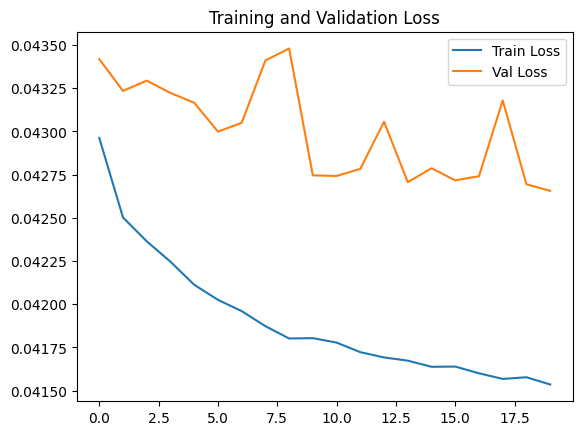

285/285 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


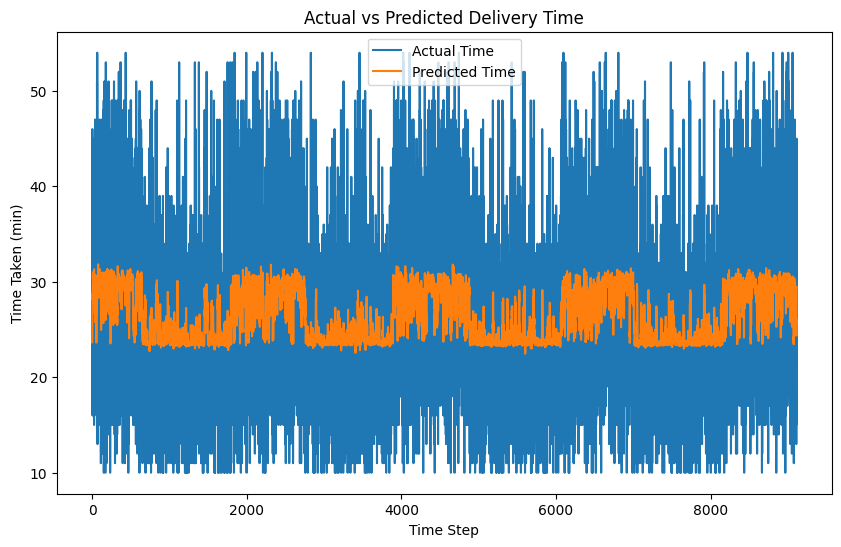

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.model_selection import train_test_split

# 1. Load and prepare data
df = pd.read_csv("/content/Zomato Dataset.csv")
df['Order_Date'] = pd.to_datetime(df['Order_Date'], dayfirst=True)
df.sort_values('Order_Date', inplace=True)
df.set_index('Order_Date', inplace=True)

# 2. Use 'Time_taken (min)' as target
df['Time_taken (min)'] = pd.to_numeric(df['Time_taken (min)'], errors='coerce')
data = df[['Time_taken (min)']].dropna()

# 3. Normalize
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data)

# 4. Create LSTM sequences
def create_sequences(dataset, time_steps=10):
    X, y = [], []
    for i in range(len(dataset) - time_steps):
        X.append(dataset[i:i+time_steps])
        y.append(dataset[i+time_steps])
    return np.array(X), np.array(y)

time_steps = 10
X, y = create_sequences(scaled_data, time_steps)

# 5. Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# 6. Build LSTM model
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(X_train.shape[1], 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

# 7. Train the model
history = model.fit(X_train, y_train, epochs=20, batch_size=16, validation_data=(X_test, y_test))

# 8. Plot training history
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

# 9. Predict and inverse transform
predicted = model.predict(X_test)
predicted_actual = scaler.inverse_transform(predicted)
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

# 10. Plot actual vs predicted
plt.figure(figsize=(10, 6))
plt.plot(y_test_actual, label='Actual Time')
plt.plot(predicted_actual, label='Predicted Time')
plt.title('Actual vs Predicted Delivery Time')
plt.xlabel('Time Step')
plt.ylabel('Time Taken (min)')
plt.legend()
plt.show()